# Project 4 - Part 3 - Train With Larger Dataset


In [110]:
import math
import random
import numpy as np
import pandas as pd
import glob
import scipy
import skimage
import skimage.io as skio
from skimage.transform import resize
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, models

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

### Define torch dataset, dataloader for immface


In [26]:
tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()

In [31]:
xml_imgs = root.findall('./images')[0]
dataset_size = len(xml_imgs)
sample = xml_imgs[0]
file_path = sample.attrib['file']
print(file_path)
box = sample.findall('./box')[0]
top, left, width, height = int(box.attrib['top']), int(box.attrib['left']), int(box.attrib['width']), int(box.attrib['height'])
kps_x, kps_y = [], []
for kp in box:
    kps_x.append(int(kp.attrib['x']))
    kps_y.append(int(kp.attrib['y']))

lfpw/trainset/image_0457.png


In [34]:
r=np.vstack([kps_x, kps_y]).T
print(r.shape)

(68, 2)


In [102]:
class IBugFaceDataset(Dataset):
    def __init__(self,
                 root_dir,
                 xml_path = None,
                 bbox_rescale_factor=1,
                 resize_res = [224, 224],
                 transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            xml_path (string): Path to the XML to load.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.xml_path = os.path.join(root_dir, 'labels_ibug_300W_train.xml') if xml_path is None else xml_path
        tree = ET.parse(self.xml_path)
        xml_root = tree.getroot()
        self.xml_imgs = xml_root.findall('./images')[0]

        self.resize_res = resize_res
        self.transform = transform
        self.bbox_rescale_factor = bbox_rescale_factor

    def __len__(self):
        return len(self.xml_imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img, keypoints_relative, orig_im = self.get_sample(idx)

        sample = {'image': img, 'keypoints': keypoints_relative, 'orig_im': orig_im}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def get_sample(self, idx):
        sample = self.xml_imgs[idx]
        file_path = sample.attrib['file']
        im = skio.imread(os.path.join(self.root_dir, file_path), as_gray=True)
        box = sample.findall('./box')[0]
        top, left, width, height = int(box.attrib['top']), int(box.attrib['left']), int(box.attrib['width']), int(box.attrib['height'])

        if self.bbox_rescale_factor != 1:
            # print('Old')
            # print(left, top, width, height)
            height_delta = height*(self.bbox_rescale_factor-1)
            width_delta = width*(self.bbox_rescale_factor-1)
            # print('Deltas')
            # print(width_delta, height_delta)
            # print('Shape')
            # print(im.shape[1], im.shape[0])
            top = max(0, int(top - height_delta/2))
            left = max(0, int(left - width_delta/2))
            # print('Midway')
            # print(left, top)
            width = min(im.shape[1] - left, int(width + width_delta)) #TODO: Check if correct
            height = min(im.shape[0] - top, int(height + height_delta))
            # print('New')
            # print(left, top, width, height)

        #crop and resize image
        face_cropped = im[top:top+height, left:left+width]
        face_cropped = resize(face_cropped, output_shape=self.resize_res)
        face_cropped = face_cropped.astype(np.float32) - 0.5

        # Get kps
        kps_x, kps_y = [], []
        for kp in box:
            kps_x.append((int(kp.attrib['x']) - left)/width)
            kps_y.append((int(kp.attrib['y']) - top)/height)

        return face_cropped, np.vstack([kps_x, kps_y]).T.astype('float32'), im

## Define augmentations

In [103]:
class Face_ToTensor(object):
    def __call__(self, sample):
        new_sample = {'image':  transforms.ToTensor()(sample['image']),
                      'keypoints': sample['keypoints']}
        return new_sample

class Face_ColorJitter(object):
    def __init__(self, **kwargs):
        self.color_jitter_args = kwargs

    def __call__(self, sample):
        new_img = transforms.ColorJitter(**self.color_jitter_args)(transforms.ToPILImage()(((sample['image']+0.5)*255).astype(np.uint8)))
        new_arr = ((np.asarray(new_img)/255) - 0.5).astype('float32')
        new_sample = {'image': new_arr,
                      'keypoints': sample['keypoints']}
        return new_sample

class Face_Shift(object):
    def __init__(self, p=1, min_x=0, min_y=0, max_x=10, max_y=10):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y
        self.p = p

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        if np.random.random() < self.p:
            x_shift_val = random.choice([-1,1])*random.uniform(self.min_x, self.max_x)
            y_shift_val = random.choice([-1,1])*random.uniform(self.min_y, self.max_y)
            image = scipy.ndimage.shift(image, [y_shift_val, x_shift_val], mode='reflect')
            keypoints[:,0]+=x_shift_val/image.shape[0]
            keypoints[:,1]+=y_shift_val/image.shape[1]
        return {'image': image,
                'keypoints': keypoints}

class Face_Rotate(object):
    def __init__(self, theta=15, p=1):
        # Theta is max angle in degrees to rotate by
        self.theta = theta
        self.p = p

    def rotate_keypoints(self, angle, keypoints, pivot_pt=0.5):
        # Pivot pt is 0.5 because keypoints are [0,1]
        # Rotation matrix
        radians = math.radians(angle)
        R = np.array([
            [np.cos(radians),  np.sin(radians)],
            [-np.sin(radians), np.cos(radians)]
        ])
        return ((R @ (keypoints - pivot_pt).T) + pivot_pt).T

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        if np.random.random() < self.p:
            rotate_angle = random.choice([-1,1])*random.uniform(0, self.theta)
            image = skimage.transform.rotate(image, angle=rotate_angle, mode='reflect', preserve_range=True)
            image = image.astype('float32')
            keypoints = self.rotate_keypoints(rotate_angle, keypoints).astype('float32')
        return {'image': image,
                'keypoints': keypoints}

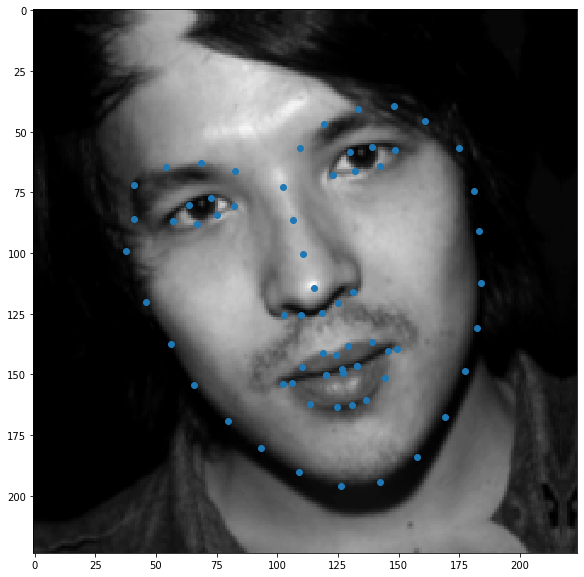

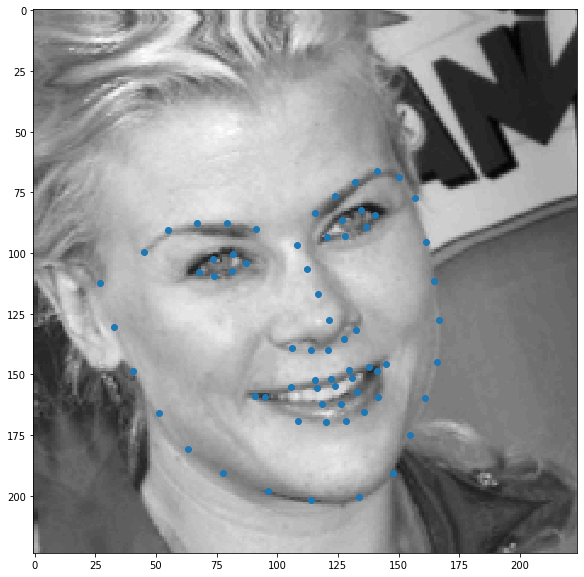

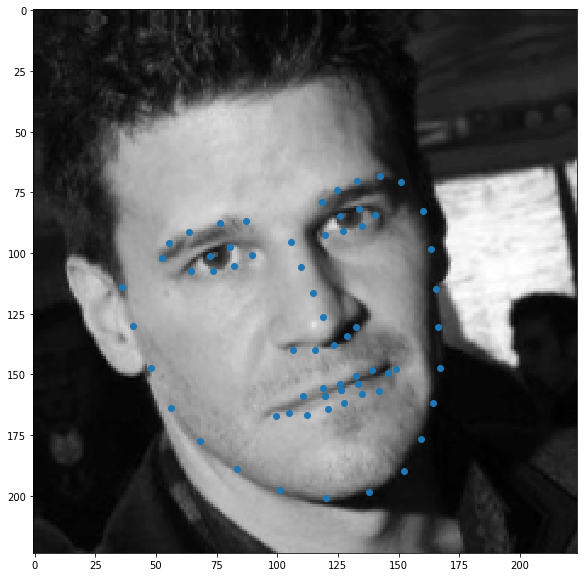

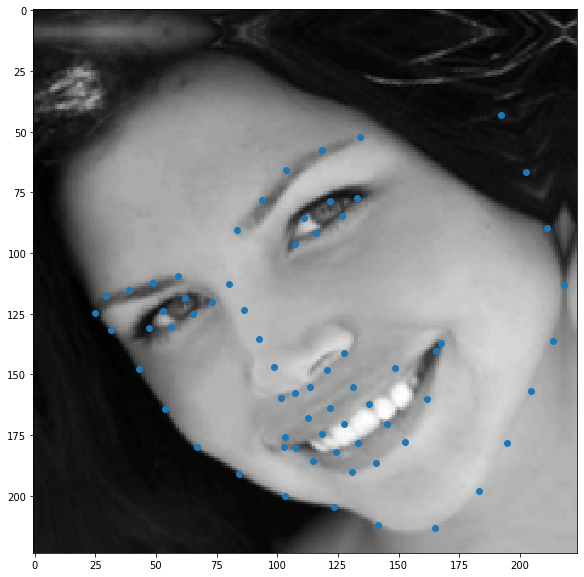

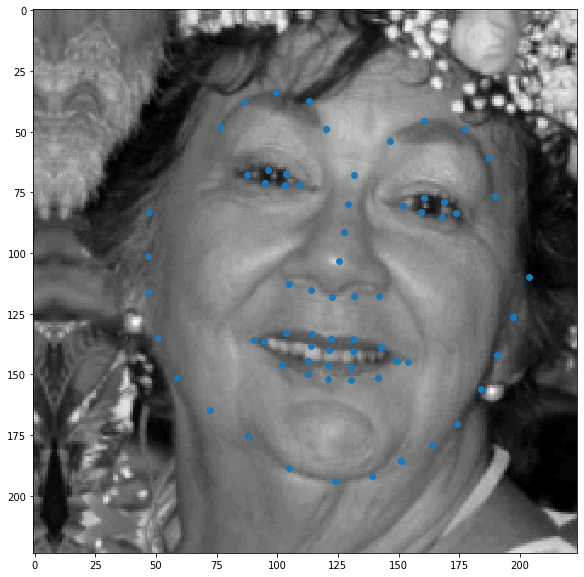

In [109]:
# Test dataset and augmentations
trf = None
trf = transforms.Compose([Face_Rotate(theta=20),
                          Face_Shift(),
                          Face_ColorJitter(brightness=[0.2,1], contrast=[0.2,1], saturation=[0.2,1], hue=[-0.5,0.5])])

ds = IBugFaceDataset(root_dir='ibug_300W_large_face_landmark_dataset',
                     xml_path='ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml',
                     transform=trf,
                     bbox_rescale_factor=1.4)

for i in [4,22,44,98,103]:#random.sample(range(0, len(ds)), 5):
    sample = ds[i]
    img, kps = sample['image'], sample['keypoints']
    plt.figure(figsize=[10,10])
    plt.imshow((img+0.5), cmap='gray')
    plt.scatter(x=kps[:,0]*img.shape[1], y=kps[:,1]*img.shape[0])
    #plt.savefig(f'out_part3/aug_{i}.jpg', bbox_inches='tight')

# Create CNN - Use Resnet


In [111]:
net = models.resnet18(pretrained=True)

# Change first layer
out_fts = net.conv1.out_channels
kernel_size = net.conv1.kernel_size
net.conv1 = nn.Conv2d(1, out_fts, kernel_size=kernel_size)

# Change last layer
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 136)
net = net.to(dev)
print(net)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, 

In [112]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)

In [114]:
trf_train = transforms.Compose([
                          Face_Rotate(theta=20),
                          Face_Shift(),
                          Face_ColorJitter(brightness=[0.2,1], contrast=[0.2,1], saturation=[0.2,1], hue=[-0.5,0.5]),
                          Face_ToTensor()])
trf_val = transforms.Compose([Face_ToTensor()])
ds_train = IBugFaceDataset(root_dir='ibug_300W_large_face_landmark_dataset',
                           xml_path='ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml',
                           transform=trf_train,
                           bbox_rescale_factor=1.4)
ds_val = IBugFaceDataset(root_dir='ibug_300W_large_face_landmark_dataset',
                           xml_path='ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml',
                           transform=trf_val,
                           bbox_rescale_factor=1.4)

# 90:10 split train:val
train_idx = int(len(ds_train)*0.9)

train_dataset = torch.utils.data.Subset(ds_train, range(0,train_idx))
val_dataset = torch.utils.data.Subset(ds_val, range(train_idx,len(ds_val)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2)

In [115]:
def get_loss(net, loader):
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(loader):
            inputs, labels = data['image'], data['keypoints']
            inputs = inputs.to(dev)
            labels = labels.to(dev)
            labels = labels.reshape([-1,68*2])
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        mean_loss = running_loss/len(loader)
    return mean_loss

In [116]:
train_losses = []
val_losses = []
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['keypoints']
        inputs = inputs.to(dev)
        labels = labels.to(dev)
        labels = labels.reshape([-1,68*2])
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 0:    # Compute metrics every 5 mini-batches
            print('[Epoch %d, Minibatch %d/%d] loss: %.3f' %
                  (epoch + 1, i + 1, len(train_loader), running_loss / 5))
            running_loss = 0.0

    # Compute loss metrics
    train_loss = get_loss(net, train_loader)
    train_losses.append(train_loss)

    val_loss = get_loss(net, val_loader)
    val_losses.append(val_loss)

    print('Epoch %d done - Train %.3f Val %.3f' % (epoch + 1, train_loss, val_loss))
print('Done')

[Epoch 1, Minibatch 1/750] loss: 0.107
[Epoch 1, Minibatch 6/750] loss: 0.414
[Epoch 1, Minibatch 11/750] loss: 0.222
[Epoch 1, Minibatch 16/750] loss: 0.117
[Epoch 1, Minibatch 21/750] loss: 0.059
[Epoch 1, Minibatch 26/750] loss: 0.034
[Epoch 1, Minibatch 31/750] loss: 0.020
[Epoch 1, Minibatch 36/750] loss: 0.014
[Epoch 1, Minibatch 41/750] loss: 0.011
[Epoch 1, Minibatch 46/750] loss: 0.009
[Epoch 1, Minibatch 51/750] loss: 0.009
[Epoch 1, Minibatch 56/750] loss: 0.007


KeyboardInterrupt: 

## Plot loss

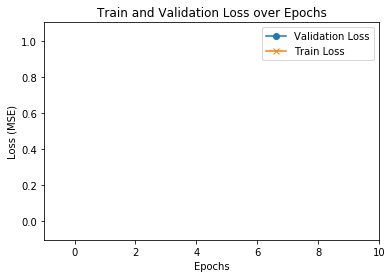

In [117]:
plt.plot(val_losses, marker='o', label='Validation Loss')
plt.plot(train_losses, marker='x', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.xlim([-1,10])
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.savefig('out_part3/loss.png', bbox_inches='tight')

# Try some sample outputs

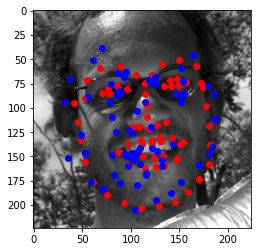

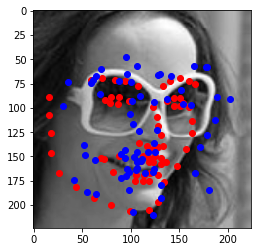

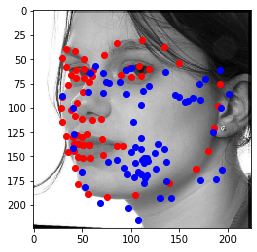

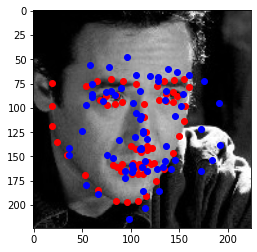

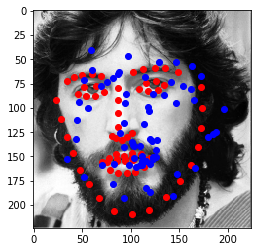

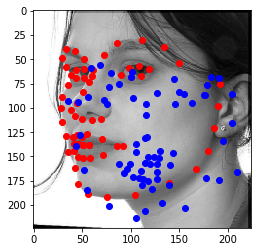

In [118]:
for idx in range(0,6):
    data = next(iter(val_loader))
    with torch.no_grad():
        inputs, labels = data['image'], data['keypoints']
        inputs = inputs.to(dev)
        labels = labels.reshape([-1,68*2])
        out = net(inputs)
    plt.figure()
    img = np.array(inputs.cpu()[idx,0,:,:])
    img = (img+0.5)*255
    plt.imshow(img,cmap='gray')

    # Plot actual kps
    true_kps = np.array(labels.reshape([-1,68,2]))
    plt.scatter(x=true_kps[idx,:,0]*img.shape[1], y=true_kps[idx,:,1]*img.shape[0], color='red')

    # Plot predicted kps
    pred_kps = np.array(out.cpu().reshape([-1,68,2]))
    plt.scatter(x=pred_kps[idx,:,0]*img.shape[1], y=pred_kps[idx,:,1]*img.shape[0], color='blue')
    #plt.savefig(f'out_part3/pred_{idx}.jpg', bbox_inches='tight')